In [1]:
import tensorflow as tf
from tensorflow import keras
from google.colab import files
from tensorflow.keras import layers, models
from tensorflow.keras.applications.densenet import DenseNet121, preprocess_input
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import IPython.display as display
import matplotlib.image as mpimg
import os, tempfile
from sklearn.metrics import classification_report, confusion_matrix

1.Dataset Loading


In [2]:
dataset_name = "imagenette"
full_dataset, info = tfds.load(dataset_name, with_info=True)


Class Labelling From imagenette


In [3]:
class_names = [
    'tench',               # n01440764
    'English springer',    # n02102040
    'cassette player',     # n02979186
    'chain saw',           # n03000684
    'church',              # n03028079
    'French horn',         # n03394916
    'garbage truck',       # n03417042
    'gas pump',            # n03425413
    'golf ball',           # n03445777
    'parachute'            # n03888257
]

Dataset Summary

In [4]:

print("IMAGENETTE DATASET (full-size-v2)")

print(f"Number of classes : {len(class_names)}")
print(f"Class names       : {class_names}")
print(f"Train images      : {info.splits['train'].num_examples}")
print(f"Validation images : {info.splits['validation'].num_examples}")



IMAGENETTE DATASET (full-size-v2)
Number of classes : 10
Class names       : ['tench', 'English springer', 'cassette player', 'chain saw', 'church', 'French horn', 'garbage truck', 'gas pump', 'golf ball', 'parachute']
Train images      : 9469
Validation images : 3925


In [5]:
#load train and validation splits
train_ds = tfds.load(dataset_name, split='train',       as_supervised=True)
val_ds   = tfds.load(dataset_name, split='validation', as_supervised=True)

In [6]:
#preprocessing
IMG_SIZE   = 224
BATCH_SIZE = 32
AUTOTUNE   = tf.data.AUTOTUNE

def preprocess(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = preprocess_input(image)  # DenseNet normalization
    return image, label

train_ds = train_ds.map(preprocess, num_parallel_calls=AUTOTUNE)
val_ds   = val_ds.map(preprocess,   num_parallel_calls=AUTOTUNE)

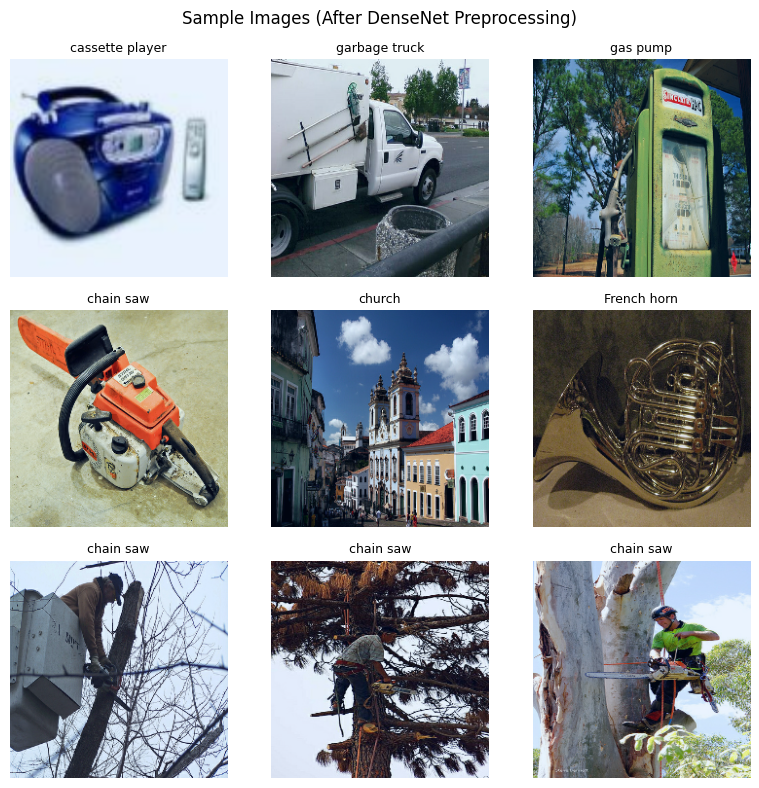

In [7]:
#Sample visualization
def show_samples(dataset, n=9):
    plt.figure(figsize=(8, 8))
    for i, (img, lbl) in enumerate(dataset.take(n)):
        ax = plt.subplot(3, 3, i + 1)
        # Normalize for display
        img_disp = img.numpy()
        img_disp = (img_disp - img_disp.min()) / (img_disp.max() - img_disp.min() + 1e-6)
        plt.imshow(img_disp)
        plt.title(class_names[int(lbl)], fontsize=9)
        plt.axis('off')
    plt.suptitle("Sample Images (After DenseNet Preprocessing)", fontsize=12)
    plt.tight_layout()
    plt.show()

show_samples(train_ds)

In [8]:
#Batch shuffle
train_ds = train_ds.shuffle(1000).batch(BATCH_SIZE).prefetch(AUTOTUNE)
val_ds   = val_ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)

In [9]:
#model building
base_model = DenseNet121(
    weights='imagenet',
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)
base_model.trainable = False  # Freeze base

model = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')
])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)        │ (None, 7, 7, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    12,845,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,885,386 (75.86 MB)

 Trainable params: 12,847,882 (49.01 MB)

 Non-trainable params: 7,037,504 (26.85 MB)

In [10]:
#model compiling
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [11]:
#model train
EPOCHS = 5
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS
)

Epoch 1/5
296/296 ━━━━━━━━━━━━━━━━━━━━ 120s 301ms/step - accuracy: 0.8542 - loss: 0.5956 - val_accuracy: 0.9855 - val_loss: 0.0442
Epoch 2/5
296/296 ━━━━━━━━━━━━━━━━━━━━ 54s 170ms/step - accuracy: 0.9789 - loss: 0.0643 - val_accuracy: 0.9865 - val_loss: 0.0432
Epoch 3/5
296/296 ━━━━━━━━━━━━━━━━━━━━ 81s 170ms/step - accuracy: 0.9862 - loss: 0.0428 - val_accuracy: 0.9824 - val_loss: 0.0500
Epoch 4/5
296/296 ━━━━━━━━━━━━━━━━━━━━ 60s 191ms/step - accuracy: 0.9907 - loss: 0.0279 - val_accuracy: 0.9908 - val_loss: 0.0389
Epoch 5/5
296/296 ━━━━━━━━━━━━━━━━━━━━ 54s 172ms/step - accuracy: 0.9921 - loss: 0.0264 - val_accuracy: 0.9896 - val_loss: 0.0397


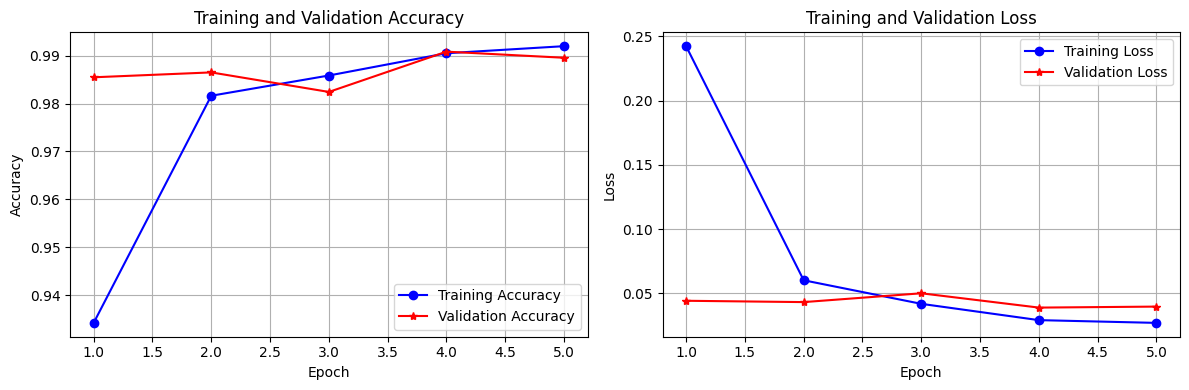

In [12]:
#plotting curves
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12, 4))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r*-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'r*-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [13]:
#Evaluation
val_loss, val_acc = model.evaluate(val_ds, verbose=0)
print(f"\nValidation Loss: {val_loss:.4f} | Validation Accuracy: {val_acc:.4f}")


Validation Loss: 0.0397 | Validation Accuracy: 0.9896



Classification Report:
                  precision    recall  f1-score   support

           tench       1.00      1.00      1.00       387
English springer       1.00      1.00      1.00       395
 cassette player       0.99      0.99      0.99       357
       chain saw       0.97      0.98      0.98       386
          church       0.99      0.99      0.99       409
     French horn       0.99      0.99      0.99       394
   garbage truck       0.99      0.99      0.99       389
        gas pump       0.99      0.97      0.98       419
       golf ball       0.99      0.99      0.99       399
       parachute       0.99      0.99      0.99       390

        accuracy                           0.99      3925
       macro avg       0.99      0.99      0.99      3925
    weighted avg       0.99      0.99      0.99      3925



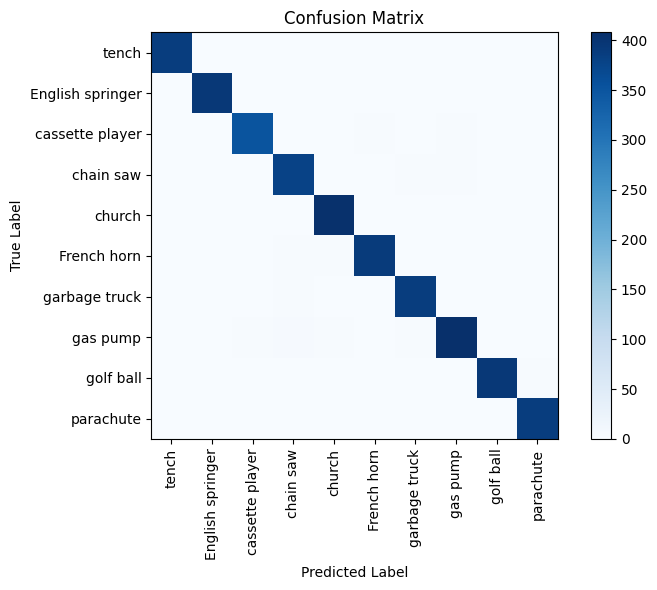

In [14]:
#classification report and confusion matrix
y_true, y_pred = [], []
for images, labels in val_ds:
    preds = np.argmax(model.predict(images, verbose=0), axis=1)
    y_true.extend(labels.numpy())
    y_pred.extend(preds)

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
plt.imshow(cm, cmap='Blues', interpolation='nearest')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.xticks(range(len(class_names)), class_names, rotation=90)
plt.yticks(range(len(class_names)), class_names)
plt.colorbar()
plt.tight_layout()
plt.show()

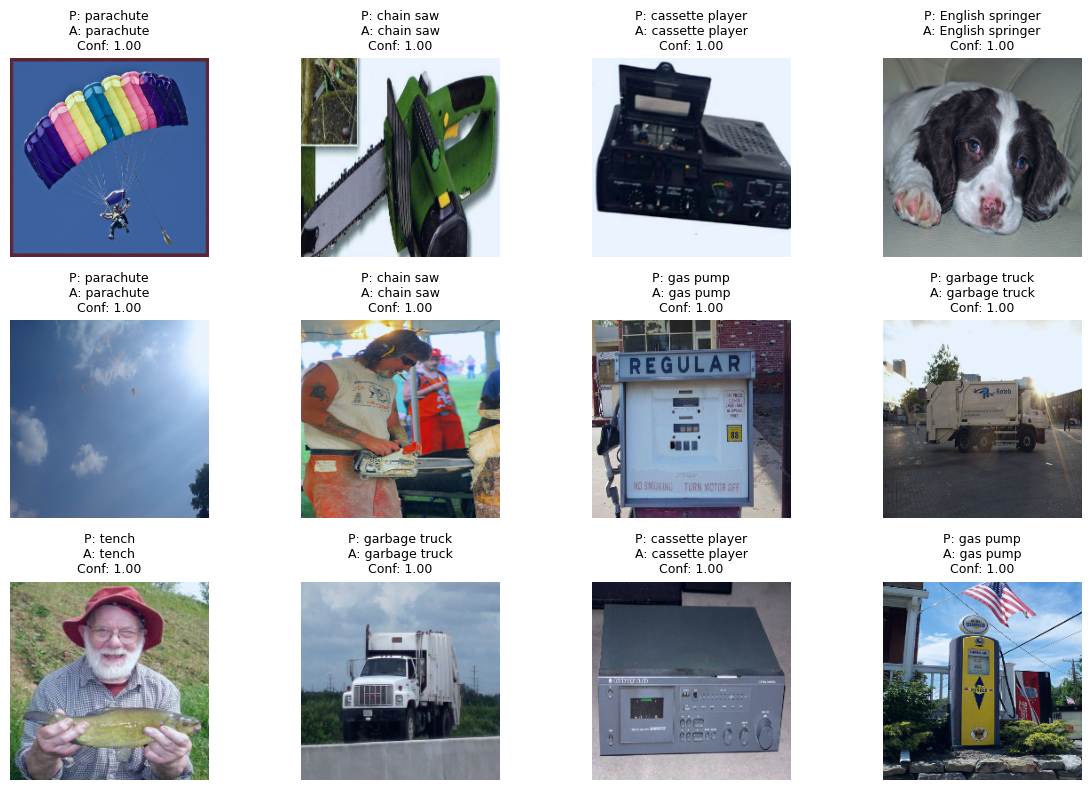

In [15]:
#Sample predictions
examples = val_ds.unbatch().take(12)
plt.figure(figsize=(12, 8))
for i, (img, lbl) in enumerate(examples):
    ax = plt.subplot(3, 4, i + 1)
    img_input = tf.expand_dims(img, 0)
    probs = model.predict(img_input, verbose=0)[0]
    pred = np.argmax(probs)
    conf = np.max(probs)

    # Display image
    img_disp = img.numpy()
    img_disp = (img_disp - img_disp.min()) / (img_disp.max() - img_disp.min() + 1e-6)
    plt.imshow(img_disp)
    plt.title(f"P: {class_names[pred]}\nA: {class_names[int(lbl)]}\nConf: {conf:.2f}", fontsize=9)
    plt.axis('off')
plt.tight_layout()
plt.show()

Please upload an image (JPG / PNG)...


Saving chain.jpg to chain.jpg
Saving tench.webp to tench (2).webp

Uploaded: chain.jpg


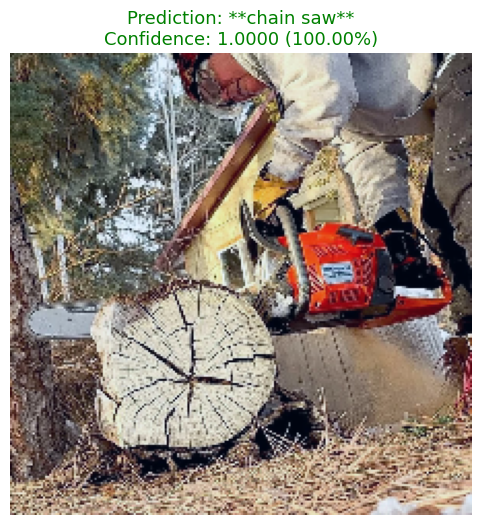


Prediction : chain saw
Confidence : 1.0000 (100.00%)


In [18]:
def predict_uploaded_image(model, class_names, img_size=224):

    print("Please upload an image (JPG / PNG)...")
    uploaded = files.upload()

    if not uploaded:
        print("No file uploaded – aborting.")
        return

    # take the first file
    filename = list(uploaded.keys())[0]
    print(f"\nUploaded: {filename}")


    img = mpimg.imread(filename)
    if img.shape[-1] == 4:
        img = img[..., :3]

    # image resizind and densenet preprocessing
    img_resized = tf.image.resize(img, (img_size, img_size))
    img_preproc = preprocess_input(img_resized)

    # adding batch dimension and prediction
    img_batch = tf.expand_dims(img_preproc, axis=0)
    probs = model.predict(img_batch, verbose=0)[0]
    pred_idx = np.argmax(probs)
    confidence = probs[pred_idx]

    # remove preprocessing
    img_disp = (img_preproc - tf.reduce_min(img_preproc)) / (tf.reduce_max(img_preproc) - tf.reduce_min(img_preproc) + 1e-6)


    # result print
    plt.figure(figsize=(6, 6))
    plt.imshow(img_disp)
    plt.title(f"Prediction: **{class_names[pred_idx]}**\n"
              f"Confidence: {confidence:.4f} ({confidence*100:.2f}%)",
              fontsize=13, color='green')
    plt.axis('off')
    plt.show()

    print(f"\nPrediction : {class_names[pred_idx]}")
    print(f"Confidence : {confidence:.4f} ({confidence*100:.2f}%)")

# function call
predict_uploaded_image(model=model, class_names=class_names, img_size=IMG_SIZE)